# 📝 Text super-resolution
* team name and members: Super-girls, **Agata Żywot 148258, Zuzanna Gawrysiak 148255**
* selected problem and dataset: Super-resolution, [TextZoom](https://paperswithcode.com/dataset/textzoom)

In [2]:
import os
import sys
if '../' not in sys.path:
    sys.path.append('../')
from IPython.display import display
import tqdm
import cv2
import PIL
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import optuna

import torch
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
print("Using torch", torch.__version__)

from src.mdb_to_jpg import mdb_to_jpg
from src.utils import *
from src.data import *
from src.models.srresnet import _NetG, _NetD
from src.models.esrgan import NetG_E, NetD_E
from src.models.esrgan_tune_hp import tune_hp
from src.models.srgan_train import sr_gan_perform_training
from src.models.srresnet_train import sr_resnet_perform_training
from src.models.gestalt import tsrn
from src.cfg import *
from src.neocr_data import *

Using torch 1.13.0+cpu


In [3]:
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
    
else:
    device = torch.device("cpu")

print(f"Using torch { torch.__version__} on {device}")

Using torch 1.13.0+cpu on cpu


In [4]:
torch.cuda.empty_cache()

## TextZoom Dataset

### Description
The TextZoom dataset is a real-world dataset that contains paired low-resolution and high-resolution images of text captured in the wild using cameras with different focal lengths.<br>Consequently, it is more authentic and challenging than synthetic data. <br><br>
Number of images in each subset:
* train set: 17367
* test set:
    * easy: 1619
    * medium: 1411
    * hard: 1343<br>
    
Exemplary images:<br><br>
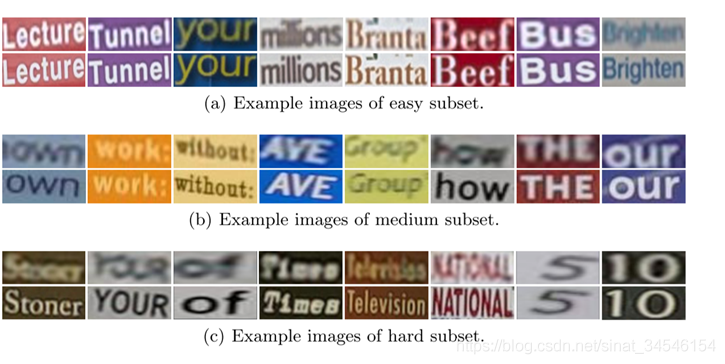

In [5]:
# TODO change for train1 at the end since it's > 10000
# load training set
data_path = 'data/TextZoom/train2_img/'
lmdb_file = 'data/TextZoom/train2'
N = mdb_to_jpg(data_path, lmdb_file)

Number of samples: 2794


In [6]:
# load the data and display examplary image
img_data = get_data_from_dir(data_path, [str(i) for i in range(1, N+1)])

### Data preprocessing

In [9]:
LR_images = list(map(lambda x: x[0].shape[:-1], img_data))
HR_images = list(map(lambda x: x[1].shape[:-1], img_data))

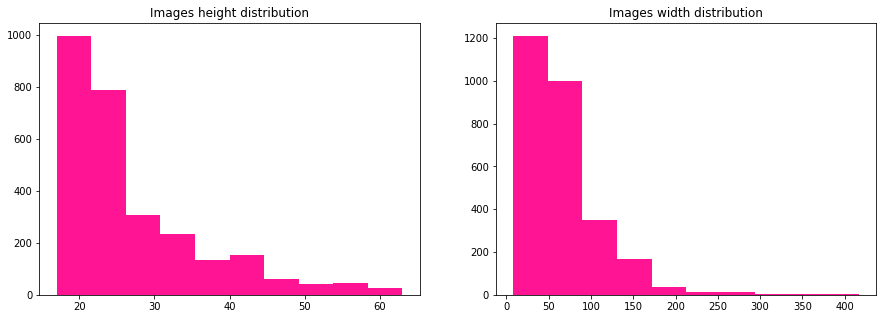

In [9]:
get_height_width_distribution(LR_images)

**NOTE: We preprocessed the data according to the paper [arXiv:2005.03341](https://arxiv.org/abs/2005.03341):** <br>
*"We up-sample the images ranging from 16-
32 pixels height to 32 pixels height, and up-sample the images ranging from 8-16
pixels height to 16 pixels height. We conclude that (16, 32) should be a good
pair to form a 2X train set for scene text SR task. For example, the text images
taken from 150mm focal length and height sized in 16-32 pixels would be taken
as a ground truth for the 70mm counterpart. So we selected all the images the
height of which range from 16 pixels to 32 pixels as our ground truth image and
up-sample them to the size of 128×32 (width×height), and the corresponding 2X
LR images to the size of 64×16 (width×height)."*

In [7]:
train_set = SRDataset(img_data)

LR shape: torch.Size([3, 16, 64])
HR shape: torch.Size([3, 32, 128])


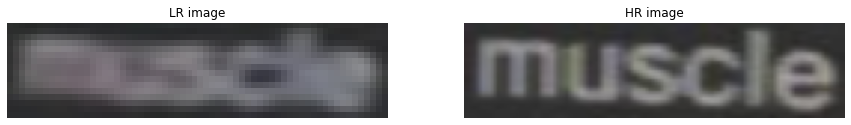

In [8]:
x = 1234

print(f'LR shape: {train_set[x][0].shape}')
print(f'HR shape: {train_set[x][1].shape}')
display_tensors([[train_set[x][0], train_set[x][1]]])

In [9]:
# load test sets
n_test = 100 # number of test instances per class - change it!!! if None, then the whole test_set will be applied
test_set = load_tests_sets(n_test=n_test, convert_mdb=False) # set convert_mb to True only initially to convert the data from mdb to jpg

EASY
MEDIUM
HARD


LR shape: torch.Size([3, 16, 64])
HR shape: torch.Size([3, 16, 64])


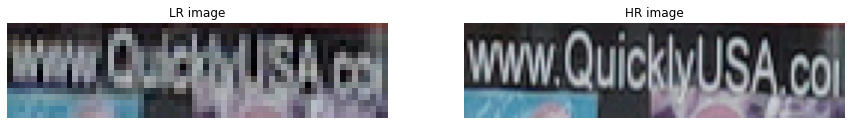

In [10]:
x=30
difficulty = 'hard'

print(f'LR shape: {test_set[difficulty][x][0].shape}')
print(f'HR shape: {test_set[difficulty][x][0].shape}')
display_tensors([[test_set[difficulty][x][0], test_set[difficulty][x][1]]])

## [NEOCR Dataset](http://www.iapr-tc11.org/dataset/NEOCR/neocr_metadata_doc.pdf)

### Description
NEOCR is a comprehensive configurable dataset with rich annotation for OCR in
natural images. The images cover a broad range of characteristics that distinguish
real world scenes from scanned documents.The dataset contains a total of 659 images with 5238 textfields. Images were
captured using various digital cameras with diverse camera settings. Because the images were taken in several
countries, 15 different languages are present in the dataset, though the visible text is limited to latin characters.

Exemplary images:<br><br>
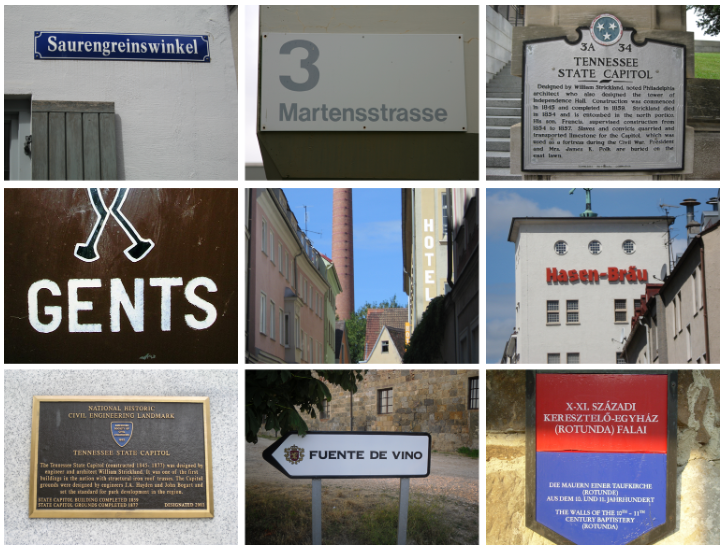

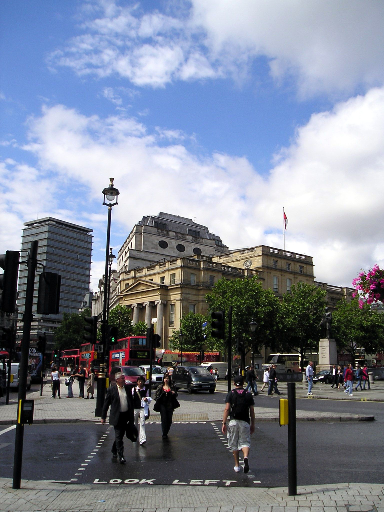

LOOK LEFT
(x1, y1): (372, 1908),	(x2, y2): (949, 1945)


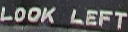

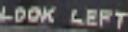

15
(x1, y1): (576, 1406),	(x2, y2): (590, 1422)


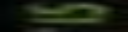

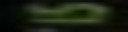

DON
(x1, y1): (115, 1391),	(x2, y2): (147, 1410)


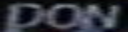

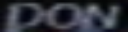

In [11]:
# EXEMPLARY IMAGE
img_path = 'data/neocr_dataset/Images/users/pixtract/dataset/img_145782.jpg'
xml_path = 'data/neocr_dataset/Annotations/users/pixtract/dataset/img_145782.xml'
neocr_images = get_text_images_from_img(img_path, xml_path, display=True);

In [12]:
n = 100 # number of images to be generated
neocr_images = get_neocr_images(n)
neocr_images_SR = SRDataset(neocr_images)

In [13]:
# EXAMPLARY NEOCR IMAGES
x = 33

LR_neocr_image = neocr_images_SR[x][0]
HR_neocr_image = neocr_images_SR[x][1]

LR shape: torch.Size([3, 16, 64])
HR shape: torch.Size([3, 32, 128])


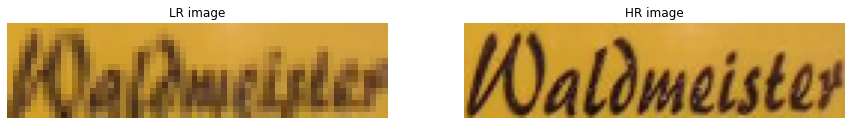

In [14]:
print(f'LR shape: {LR_neocr_image.shape}')
print(f'HR shape: {HR_neocr_image.shape}')
display_tensors([[LR_neocr_image, HR_neocr_image]])

## Evaluation metrics 

* **Peak signal-to-noise ratio (PSNR)** - defined as the ratio between the peak signal power and the power of the noise in the signal, measured in decibels (dB). It is a relative measure of the amount of noise present in the signal compared to the maximum possible signal power. The higher the PSNR value, the better the quality of the compressed signal is considered to be.<br><br>
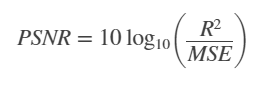

* **Structural Similarity (SSIM)** - perceptual metric that quantifies image quality degradation (resolution-based in our case). It is based on three main components: luminance, contrast, and structure. The first component, luminance, is calculated by averaging the pixel values in the image. The second component, contrast, is calculated by comparing the standard deviation of the pixel values to a reference value. The third component, structure, is calculated by comparing the correlation of pixel values in small windows across the image.<br><br>
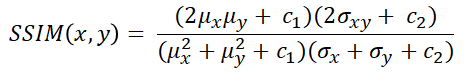

## Models

### SRResNet

SRResNet (Super-Resolution Residual Network) neural network uses a combination of convolutional layers and residual blocks to learn and apply a mapping from low-resolution to high-resolution images. The architecture is based on the idea of using residual connections, which helps to improve the quality of the resulting images by allowing the network to better preserve fine details. SRResNet also uses a technique called sub-pixel convolution which helps to further increase the resolution of the output image.

#### Overall architecture
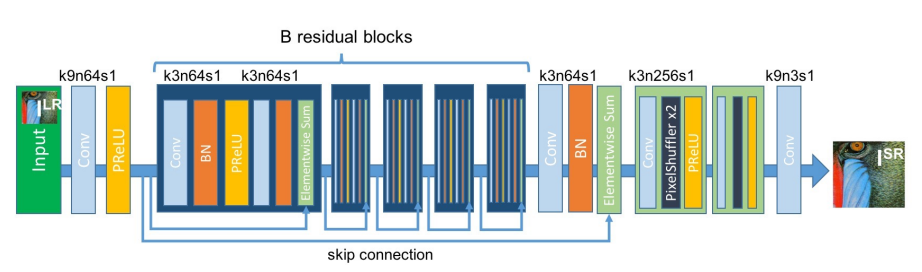

#### Model analysis
* size: 5,4MB
* number of parameters: 1,4M
* used loss functions: VGG loss, MSE 

In [9]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 100

sr_resnet_perform_training(train_set=train_set, cfg=cfg, test_set=test_set, save='new', verbose=False)

#### Exemplary predictions

In [15]:
checkpoint = torch.load('checkpoint/model_new.pth', map_location=torch.device(device))
sr_resnet = checkpoint['model']
sr_resnet = sr_resnet.eval()

In [16]:
x = 20
difficulty = 'hard'
LR_image = test_set[difficulty][x][0]
HR_image = test_set[difficulty][x][1]
SR_image = get_prediction(LR_image.to(device), sr_resnet)

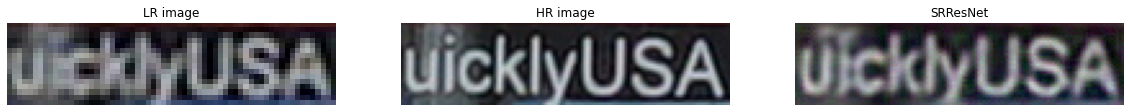

In [17]:
display_tensors([[LR_image, HR_image, SR_image]], title_list=["SRResNet"], figsize=(20, 5))

In [18]:
_, _ = get_stats(HR_image, SR_image)

PSNR :19.150
SSIM: 0.396


In [19]:
avg_psnr, avg_ssim = evaluate_model(sr_resnet, test_set)

In [20]:
print(f'PSNR: {avg_psnr}')
print(f'SSIM: {avg_ssim}')

PSNR: {'easy': 27.09961206812469, 'medium': 19.160109272202238, 'hard': 21.198872020074404}
SSIM: {'easy': 0.680207788132373, 'medium': 0.34044841199953946, 'hard': 0.420375349133467}


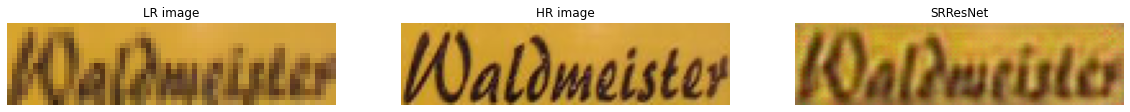

In [21]:
# CHECK WITH NEOCR DATA
SR_neocr_image = get_prediction(LR_neocr_image.to(device), sr_resnet)
display_tensors([[LR_neocr_image, HR_neocr_image, SR_neocr_image]], title_list=["SRResNet"], figsize=(20, 5))

### SRGAN

#### Model analysis
* size: 5,4MB
* number of parameters: 14,37M
* used loss functions: VGG loss, MSE 

In [25]:
mini_train_set = torch.utils.data.Subset(train_set, range(50))

In [27]:
cfg = read_config("cfg/models/srresnet.yaml")
cfg['epochs'] = 10
# cfg['beta']=0.1

# sr_gan_perform_training(train_set=train_set, cfg=cfg, run_neptune=False)
sr_gan_perform_training(train_set=mini_train_set, test_set=test_set, cfg=cfg, pretrained='checkpoint/model_new.pth', run_neptune=False ,save='mini_gan')

#### Sample prediction

In [22]:
checkpoint = torch.load('checkpoint/model_mini_gan.pth', map_location=torch.device(device))
sr_gan = checkpoint['model']
sr_gan = sr_gan.eval()

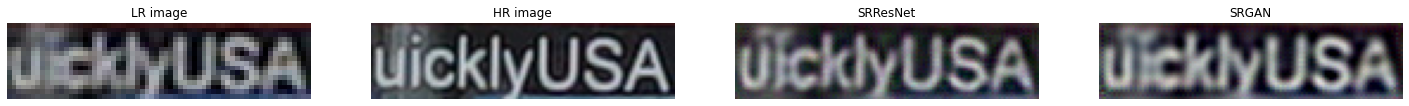

In [23]:
# SRGAN
SRGAN_image = get_prediction(LR_image.to(device), sr_gan)
display_tensors([[LR_image, HR_image, SR_image, SRGAN_image]], title_list=["SRResNet", "SRGAN"], figsize=(25, 5))

In [173]:
_, _ = get_stats(HR_image, SRGAN_image)

PSNR :18.102
SSIM: 0.338


In [174]:
avg_psnr, avg_ssim = evaluate_model(sr_gan, test_set)

In [175]:
print(f'PSNR: {avg_psnr}')
print(f'SSIM: {avg_ssim}')

PSNR: {'easy': 26.179160015856166, 'medium': 18.2512728845448, 'hard': 20.84151097322876}
SSIM: {'easy': 0.6517179900514679, 'medium': 0.3353734985652139, 'hard': 0.3962808801404513}


### ESRGAN
Here we propose our own architecture loosely based on the Enhanced Super-Resolution Generative Adversarial Networks. We implemented Residual in Residual Dense Block, which should boost performance. Moreover, Batch Normalization was removed to reduce computational complexity. As the paper states: *BN layers tend to introduce unpleasant artifacts and limit the generalization ability.*

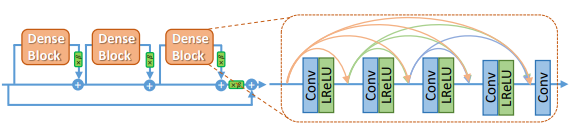

Training generator first.

In [67]:
cfg = read_config("cfg/models/esrgan.yaml")
cfg['epochs'] = 10

sr_resnet_perform_training(train_set=train_set, cfg=cfg, generative_model=NetG_E(), test_set=test_set,
                           vgg_loss=True, run_neptune=True, save='e', verbose=False)

#### Sample predictions

In [24]:
checkpoint = torch.load('checkpoint/model_e.pth', map_location=torch.device(device))
esr_model = checkpoint['model']
esr_model = esr_model.eval()

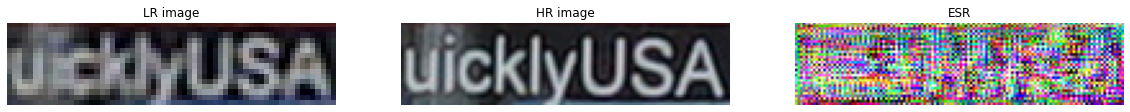

In [25]:
ESR_image = get_prediction(LR_image.to(device), esr_model)
display_tensors([[LR_image, HR_image, ESR_image]], title_list=["ESR"], figsize=(20, 5))

Training the whole GAN with pretrained generator.

In [73]:
cfg = read_config("cfg/models/esrgan.yaml")
cfg['epochs'] = 10

sr_gan_perform_training(train_set=train_set, test_set=test_set, cfg=cfg,
                        generative_model=NetG_E(), discriminative_model=NetD_E(), vgg_loss=True,
                        pretrained='checkpoint/model_e.pth', save='egan', verbose=False)


#### Sample predictions

In [26]:
checkpoint = torch.load('checkpoint/model_egan.pth', map_location=torch.device(device))
esr_gan = checkpoint['model']
esr_gan = esr_gan.eval()

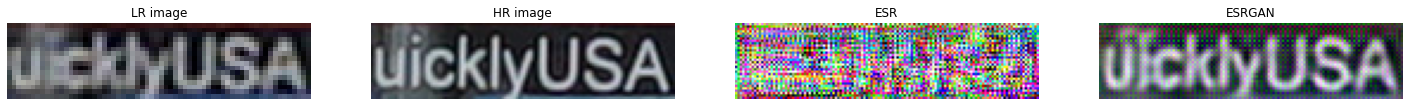

In [27]:
ESRGAN_image = get_prediction(LR_image.to(device), esr_gan)
display_tensors([[LR_image, HR_image, ESR_image, ESRGAN_image]], title_list=["ESR","ESRGAN"], figsize=(25, 5))

#### Tuning hyperparameters
We use Optoma framework to tune `batch_size`, `lr` and `momentum`. The search is based on TPE sampler, which is a form of Bayesian Optimization.

In [4]:
# + dropout probability?
study = tune_hp()

[I 2023-01-19 14:08:31,768] A new study created in memory with name: no-name-b55f6530-ea01-42a2-b8ca-7d5a4ba03fc4


  0%|          | 0/2 [00:00<?, ?it/s]

EASY
MEDIUM
HARD
[I 2023-01-19 14:30:53,111] Trial 0 finished with value: 4.648855446081541 and parameters: {'batch_size': 24, 'lr': 0.001397232287104833, 'momentum': 0.8017164579077732}. Best is trial 0 with value: 4.648855446081541.
EASY
MEDIUM
HARD
[I 2023-01-19 14:57:38,805] Trial 1 finished with value: -7.677393764270957 and parameters: {'batch_size': 8, 'lr': 8.332011982213856e-05, 'momentum': 0.5513730154007132}. Best is trial 0 with value: 4.648855446081541.
Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  4.648855446081541
  Params: 
    batch_size: 24
    lr: 0.001397232287104833
    momentum: 0.8017164579077732


In [5]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.tail(5)

,value,params_batch_size,params_lr,params_momentum
0,4.648855,24,0.001397,0.801716
1,-7.677394,8,0.000083,0.551373


<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

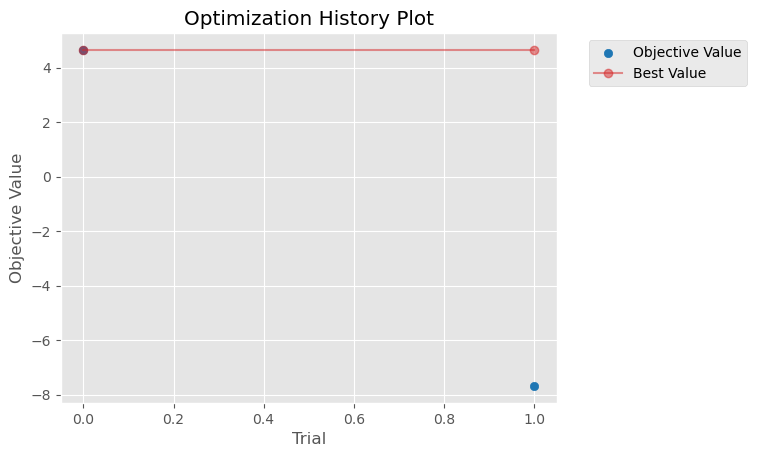

In [6]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot: title={'center': 'Parallel Coordinate Plot'}>

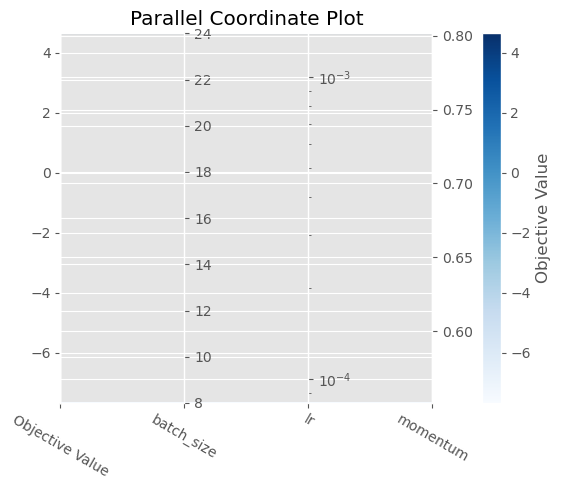

In [7]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

### Text Gestalt

The next tested model is based on the paper ["Text Gestalt: Stroke-Aware Scene Text Image Super-Resolution"](https://arxiv.org/pdf/2112.08171v1.pdf). We used code available at [GitHub](https://github.com/FudanVI/FudanOCR/tree/main/text-gestalt) and trained the net architecture from scratch.

The model is inspired by Gestalt Psychology, which states that humans can construct the complete appearance of object with the guidance of local details. Therefore English characters can be decomposed as follows:

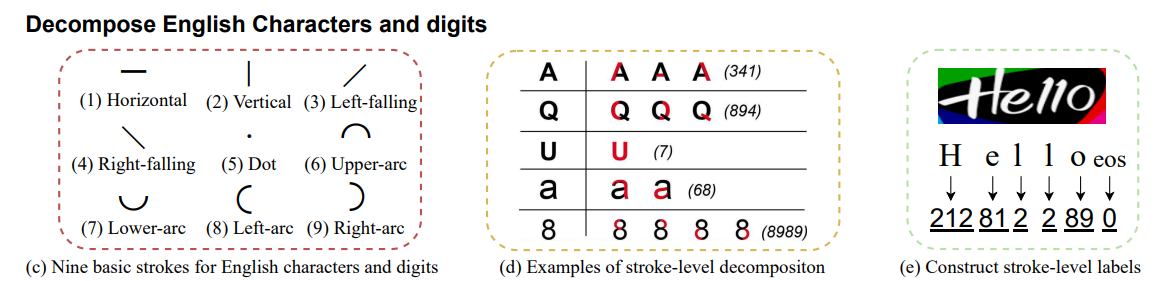
#### Overall architecture
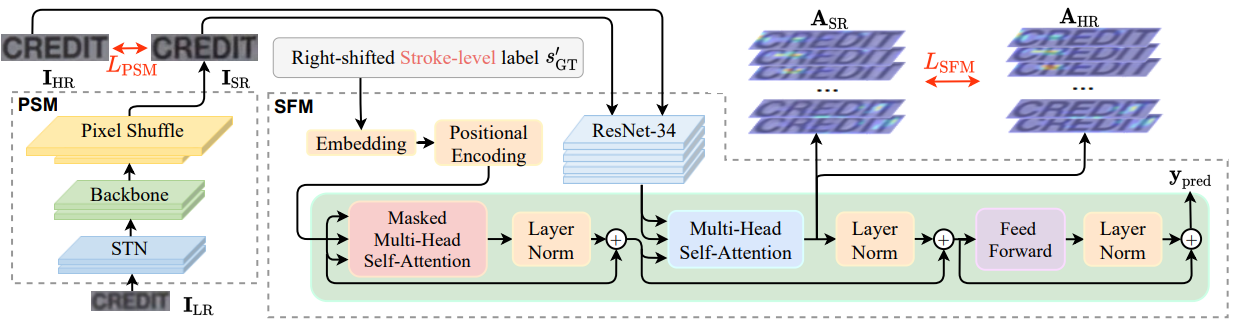

It is worth noticining that the model uses [Multi-Head Self-Attention](https://arxiv.org/pdf/1706.03762v5.pdf) to generate stroke-level maps.
#### Model analysis
* size: 10.3MB
* number of parameters: 2671020
* used metrics: 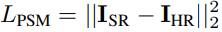
#### Learning curves

#### Sample images

In [28]:
checkpoint = torch.load('checkpoint/gestalt.pth', map_location=torch.device(device))
gestalt = tsrn.TSRN(STN=True)
gestalt.to(device)
gestalt.load_state_dict(checkpoint['state_dict_G'])
gestalt.eval();

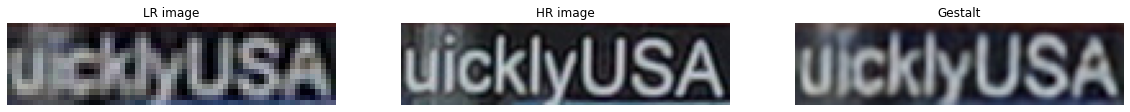

In [29]:
SR_gestalt_image = gestalt(torch.unsqueeze(LR_image, dim=0).float()).detach()[0]

# rescale from [0; 1] to [-1;1] 
SR_gestalt_image = SR_gestalt_image.mul(2).sub(1)
display_tensors([[LR_image, HR_image, SR_gestalt_image]], title_list=["Gestalt"], figsize=(20,5))